In [66]:
# 7 (a) ***************************
# Final changes (add error in ap values (y-axis))

# Args sent to emceee --> eb:  2D array, ap: 2D array, Q_list: 1D array
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd
from myfunctions import Lambda_KaplanMeierEstimate as L_KME
from myfunctions import p_expit_emcee as p_ex_em
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from scipy.optimize import curve_fit

Ne,Na = 50,50
ebs = np.linspace(0.0,0.8,Ne)

aps = np.linspace(1.0,5.0,Na)
Q_list = [1e1,1e2,1e3,1e4,1e16]

# Q_num = [1,2,3,4]
print(aps)

end_time = 62831

# From emcee (H&W Kanah.ipynb)
#c0,c1,c2 = 2.347,3.059,-1.386


eb_x = []
ap_y = []
Q_x = []

error = 0.08163265
diff = error/2

for k,Q in enumerate(Q_list):
#     print(k)
    for i, eb in enumerate(ebs):
#         print(i)
        for j, ap in enumerate(aps):
#             print(j)
            if Q > 1e4:
                filename = f'/mnt/raid-cita/ksmith/cste_Qinf/raw_surv_time_Qinf_eb{eb:.3f}_ap{ap:0.3f}.npy'
            else:
                filename = f'/mnt/raid-cita/ksmith/cste_Q{k+1}/raw_surv_time_Q{Q:.1f}_eb{eb:.3f}_ap{ap:0.3f}.npy'
            try:
                stime = np.load(filename)
            except:
                stime = np.loadtxt(filename)
#                 print(stime)
            if all(stime > end_time):
                eb_x.append(eb)
                ap_y.append(ap-diff)
                break
    Qval = [Q]*Ne
    Q_x.append(Qval)
    

#********************************************************
#List to array    
eb_x = np.asarray(eb_x)
ap_y = np.asarray(ap_y)
Q_x = np.asarray(Q_x)
# print((eb_x))
# print((ap_y))
Q_x = Q_x.flatten()
# print((Q_x)) 





[1.         1.08163265 1.16326531 1.24489796 1.32653061 1.40816327
 1.48979592 1.57142857 1.65306122 1.73469388 1.81632653 1.89795918
 1.97959184 2.06122449 2.14285714 2.2244898  2.30612245 2.3877551
 2.46938776 2.55102041 2.63265306 2.71428571 2.79591837 2.87755102
 2.95918367 3.04081633 3.12244898 3.20408163 3.28571429 3.36734694
 3.44897959 3.53061224 3.6122449  3.69387755 3.7755102  3.85714286
 3.93877551 4.02040816 4.10204082 4.18367347 4.26530612 4.34693878
 4.42857143 4.51020408 4.59183673 4.67346939 4.75510204 4.83673469
 4.91836735 5.        ]


/tmp/ipykernel_1555734/1404432140.py:15: RuntimeWarning: overflow encountered in square
  return -0.5 * np.sum((y - model) ** 2 / sigma2)
/cita/modules/python/3.10.2/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/tmp/ipykernel_1555734/1404432140.py:15: RuntimeWarning: overflow encountered in square
  return -0.5 * np.sum((y - model) ** 2 / sigma2)


Maximum likelihood estimates:
c0 is 2.29708
c1 is 3.13079
c2 is -1.49185
d9*eb**9 is -24.73931
alpha is -0.33056


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:14<00:00, 339.05it/s]


(9600, 5)


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

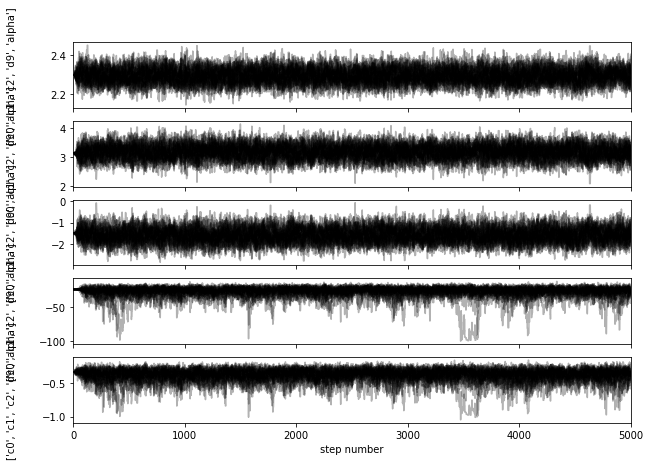

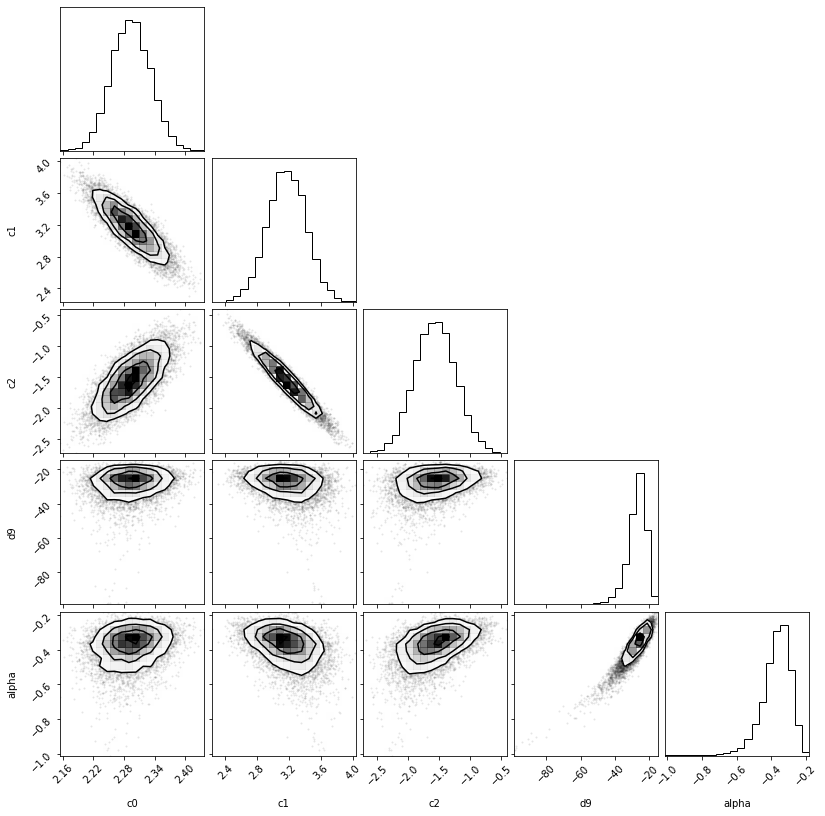

In [67]:
# 7 (b) 
#For c0,c1,c2,d9,alpha
#3D emcee d9
#Args sent to emceee --> eb:  2D array, ap: 2D array, Q_list: 1D array
            
#Increased bounds from: -10.0 < d9 < 10.0 and -0.5 < alpha < -0.25
#Finding d9 using EMCEE
#     Q_list = [1e1,1e2,1e3,1e4,1e16]
#     Q_x = np.asarray(Q_list)
#x = eb val, Q val, y = ap val
def log_likelihood(theta, x, y, Q):
    c0,c1,c2,d9,alpha = theta
    model = c0 + c1*x + c2*x**2 +d9*Q**(alpha)*x**9
    sigma2 = 0.04
    return -0.5 * np.sum((y - model) ** 2 / sigma2)

def log_prior(theta):
    c0,c1,c2,d9, alpha = theta
    if -100.0 < c0 < 100.0 and -100.0 < c1 < 100.0 and -100.0 < c2 < 100.0 and -100.0 < d9 < 100.0 and -2 < alpha < 2:
        return 0.0
    return -np.inf

def log_probability(theta, x, y, Q):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, x, y, Q)

from scipy.optimize import minimize
np.random.seed(42)
nll = lambda *args: -log_likelihood(*args)


initial = np.array([1.0,1.0,1.0,-1.0,-0.01]) 
soln = minimize(nll, initial, args=(eb_x,ap_y,Q_x))

c0,c1,c2,d9,alpha = soln.x

print("Maximum likelihood estimates:")
print("c0 is {0:.5f}".format(c0))
print("c1 is {0:.5f}".format(c1))
print("c2 is {0:.5f}".format(c2))
print("d9*eb**9 is {0:.5f}".format(d9))
print("alpha is {0:.5f}".format(alpha))


#************
import emcee
nwalkers, ndim = 32, 5
pos = soln.x + 1e-4 * np.random.randn(nwalkers, ndim)
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_probability, args=(eb_x, ap_y, Q_x)
)
sampler.run_mcmc(pos, 5000, progress=True);

#*************
fig, axes = plt.subplots(5,1, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["c0","c1", "c2","d9","alpha"]


for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels)
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

#************
flat_samples = sampler.get_chain(discard=500, thin=15, flat=True)
print(flat_samples.shape)
import corner
fig = corner.corner(
    flat_samples, labels=labels, truths=['c0','c1','c2','d9','alpha']
);

# plt.savefig('Corner Plot 06-12-2023(error).png', dpi = 250)

#*********
from IPython.display import display, Math
for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[2], q[0], q[1], labels[i])
    display(Math(txt))


# plt.savefig('KanahData_(error)06_12_2023.png', dpi = 250)


In [68]:
#Aug 2023

N_res = np.linspace(1,8,8)
print(N_res)
ap_N = np.zeros(len(N_res))
for n,N in enumerate(N_res):
    ap_N[n] = N**(2/3)
# ap_N= 1 / np.power(2, 2/3) * (1 - np.sqrt(1 - ebs**2))

print(ap_N)


[1. 2. 3. 4. 5. 6. 7. 8.]
[1.         1.58740105 2.08008382 2.5198421  2.92401774 3.30192725
 3.65930571 4.        ]


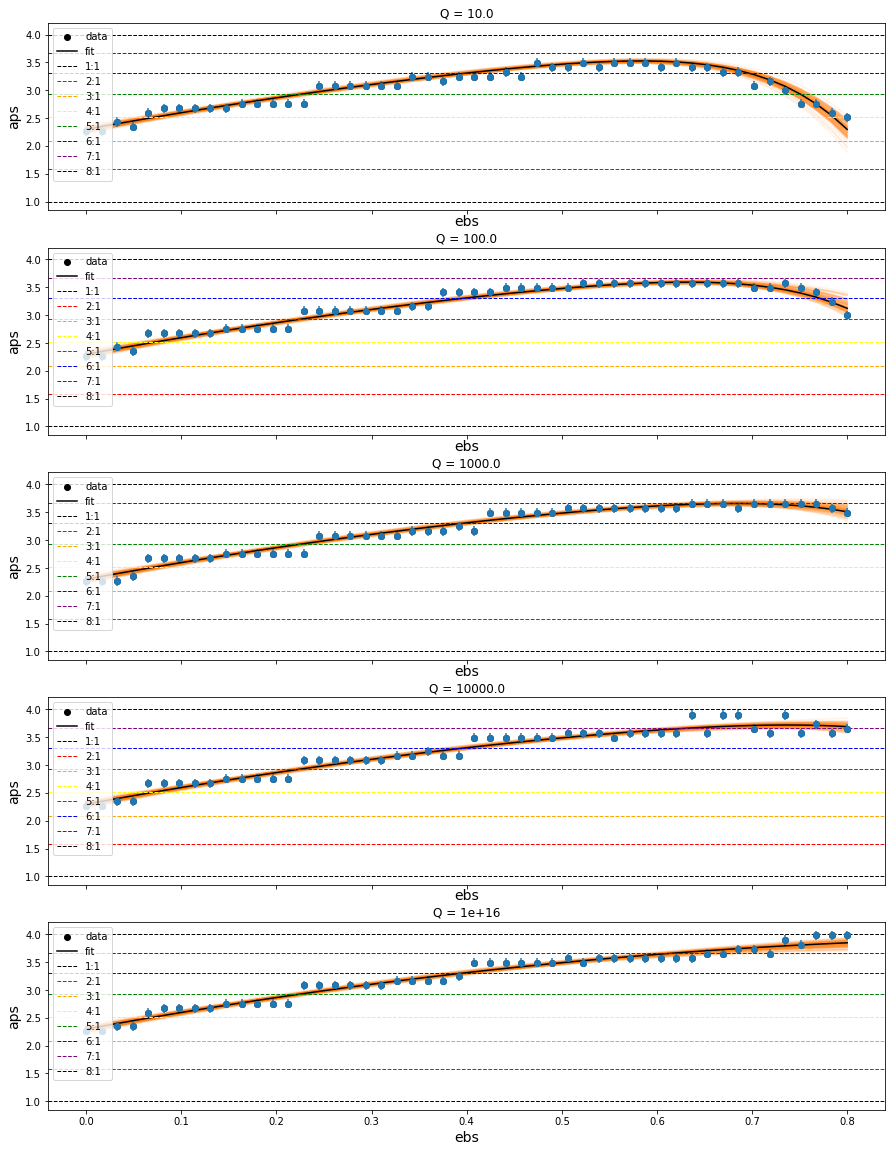

In [70]:
# 7 (c)c0,c1,c2,d9, alpha (Diagnostic Plot - Uncertainity, changed ap values)

def model(x, Q, c0,c1,c2,d9,alpha):
    # ebs = x (array of 50 values)
    # Q (array) --> try with and without Q-inf
    model = c0 + c1*x + c2*x**2 +d9*Q**(alpha)*x**9
    return model 

inds= np.random.randint(len(flat_samples), size = 100)

fig, axes = plt.subplots(5,1, figsize=(15,20), sharex = True, sharey= True)
for k,Q in enumerate(Q_list):
    for ind in inds:
        sample= flat_samples[ind]
        ax = axes[k]
        ax.plot(ebs, model(ebs,Q,sample[0], sample[1], sample[2], sample[3], sample[4]),"C1", alpha = 0.1)
        ax.set_title('Q = {}'.format(Q))
        ax.set_xlabel('ebs', fontsize = "14")
        ax.set_ylabel('aps', fontsize = "14")

c = ["red", "orange", "yellow", "green", "blue", "purple", "black"]

l,m = 0,50
for k,Q in enumerate(Q_list):
    ax = axes[k]
    ax.scatter(ebs,ap_y[l:m], color = "k", label = "data")
    ax.errorbar(ebs,ap_y[l:m],yerr = error, fmt = "o")
    ebs = np.asarray(ebs)
    ax.plot(ebs,model(ebs,Q,c0,c1,c2,d9,alpha), color = "k", label = "fit")
    
    #Resonance
    for n,N in enumerate(ap_N):
        ax.axhline(y = ap_N[n], color = c[n-1], linestyle = '--', linewidth = '1', label = "{}:1".format(n+1))
        
    l = l + 50
    m = m + 50
    ax.legend(loc='upper left')


# plt.savefig('Resonance_Plot_08-3-2023.png', dpi = 250)
        
